In [1]:
import os
import numpy as np
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
import pydicom
import random
import matplotlib.pyplot as plt
import glob
import matplotlib.patches as patches

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from skimage import morphology
from skimage.filters import threshold_otsu, threshold_local

import cv2

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from sklearn.model_selection import train_test_split

import keras
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import random
import pandas as pd

import albumentations as A

plt.style.use("ggplot")

Using TensorFlow backend.


In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '2,3'                        
import tensorflow as tf
import keras.backend as K
K.tensorflow_backend._get_available_gpus()

W0419 13:59:40.158502 19764 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0419 13:59:40.159505 19764 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0419 13:59:40.160504 19764 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0419 13:59:46.159713 19764 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']

In [11]:
images = glob.glob('Z:/Lisa/PARISK/PARISK-XNAT/plaque_converted_unempty slices/*/T1W_*.dcm')
contours = glob.glob('Z:/Lisa/PARISK/PARISK-XNAT/plaque_converted_unempty slices/*/MASSExport/*.dcm')

In [12]:
len(images), len(contours)

(2294, 2309)

In [13]:
sub_names_list = []
for image in images:
    sub_name = image.split(os.sep)[1].split('_')[0]
    con_names = glob.glob(os.path.join(os.path.split(image)[0],'MASSExport')+os.sep+'*'+ image.split(os.sep)[2][-10:-4]+'*.dcm')
    if len(con_names)>0:
        sub_names_list.append(sub_name)
        
sub_names = np.unique(sub_names_list)

In [14]:
sub_names_amc = []
sub_names_mumc = []
sub_names_umcu = []

for sub_name in sub_names:
    if 'AMC' in sub_name:
        sub_names_amc.append(sub_name)
    if 'MUMC' in sub_name:
        sub_names_mumc.append(sub_name)
    if 'UMCU' in sub_name:
        sub_names_umcu.append(sub_name)
        
print (len(sub_names_amc), len(sub_names_mumc), len(sub_names_umcu))

13 115 25


In [15]:
sub_names_amc_train, sub_names_amc_valid_test = train_test_split(sub_names_amc, test_size=0.3, 
                                                                 random_state=2022, shuffle=True)
sub_names_amc_valid, sub_names_amc_test = train_test_split(sub_names_amc_valid_test, test_size=0.5, 
                                                           random_state=2022, shuffle=True)

sub_names_mumc_train, sub_names_mumc_valid_test = train_test_split(sub_names_mumc, test_size=0.3, 
                                                                 random_state=2022, shuffle=True)
sub_names_mumc_valid, sub_names_mumc_test = train_test_split(sub_names_mumc_valid_test, test_size=0.5, 
                                                           random_state=2022, shuffle=True)

sub_names_umcu_train, sub_names_umcu_valid_test = train_test_split(sub_names_umcu, test_size=0.3, 
                                                                 random_state=2022, shuffle=True)
sub_names_umcu_valid, sub_names_umcu_test = train_test_split(sub_names_umcu_valid_test, test_size=0.5, 
                                                           random_state=2022, shuffle=True)

In [16]:
print (len(sub_names_amc_train), len(sub_names_mumc_train), len(sub_names_umcu_train))
print (len(sub_names_amc_valid), len(sub_names_mumc_valid), len(sub_names_umcu_valid))
print (len(sub_names_amc_test), len(sub_names_mumc_test), len(sub_names_umcu_test))

9 80 17
2 17 4
2 18 4


|DS | Total  | Train    | Valid   | Test   |
|---:|:-------------|:-----------|:------|:------|
| AMC | 13  | 9       | 2   | 2     |
| MUMC | 115  | 80    | 17   | 18     |
| UMCU | 25  | 17    | 4   | 4     |
| Total | 153  | 106    | 23   | 24     |

In [17]:
sub_names_train = sub_names_amc_train + sub_names_mumc_train + sub_names_umcu_train
sub_names_valid = sub_names_amc_valid + sub_names_mumc_valid + sub_names_umcu_valid
sub_names_test = sub_names_amc_test + sub_names_mumc_test + sub_names_umcu_test

In [135]:
sub_names_test

['AMC012',
 'AMC006',
 'MUMC094',
 'MUMC027',
 'MUMC079',
 'MUMC052',
 'MUMC127',
 'MUMC071',
 'MUMC038',
 'MUMC093',
 'MUMC107',
 'MUMC022',
 'MUMC114',
 'MUMC115',
 'MUMC069',
 'MUMC130',
 'MUMC036',
 'MUMC007',
 'MUMC059',
 'MUMC080',
 'UMCU036',
 'UMCU025',
 'UMCU008',
 'UMCU034']

In [18]:
img_names_train = []
img_names_valid = []
img_names_test = []

for sub_name_train in sub_names_train:
    img_names_train.extend(glob.glob('Z:/Lisa/PARISK/PARISK-XNAT/plaque_converted_unempty slices/'+sub_name_train+'*/T1W_*.dcm'))

for sub_name_valid in sub_names_valid:
    img_names_valid.extend(glob.glob('Z:/Lisa/PARISK/PARISK-XNAT/plaque_converted_unempty slices/'+sub_name_valid+'*/T1W_*.dcm'))
    
for sub_name_test in sub_names_test:
    img_names_test.extend(glob.glob('Z:/Lisa/PARISK/PARISK-XNAT/plaque_converted_unempty slices/'+sub_name_test+'*/T1W_*.dcm'))
    
print (len(img_names_train), len(img_names_valid), len(img_names_test))

1589 345 360


In [19]:
im_side = 64
im_width = im_side
im_height = im_side
border = 5

In [20]:
X_train = np.zeros((len(img_names_train), im_side, im_side, 1), dtype = np.uint8)
y_train = np.zeros((len(img_names_train), im_side, im_side, 1), dtype = np.uint8)

X_valid = np.zeros((len(img_names_valid), im_side, im_side, 1), dtype = np.uint8)
y_valid = np.zeros((len(img_names_valid), im_side, im_side, 1), dtype = np.uint8)

X_test = np.zeros((len(img_names_test), im_side, im_side, 1), dtype = np.uint8)
y_test = np.zeros((len(img_names_test), im_side, im_side, 1), dtype = np.uint8)

In [21]:
def path2array(dcm_path):
    arr_dcm = pydicom.read_file(dcm_path, force = True)
    arr_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
    arr = arr_dcm.pixel_array
    return arr

In [22]:
def norm_crop(img_arr, con_arr, im_side):
    
    img_min = np.min(img_arr) 
    img_max = np.max(img_arr) 
    
    img_norm = np.copy((img_arr - img_min)/(img_max - img_min)*255).astype(np.uint8)

    con_xmin = np.min(np.where(con_arr > 0)[0])
    con_xmax = np.max(np.where(con_arr > 0)[0])
    con_ymin = np.min(np.where(con_arr > 0)[1])
    con_ymax = np.max(np.where(con_arr > 0)[1])
        
    side_x = con_xmax - con_xmin
    side_y = con_ymax - con_ymin

    crop_xmin = max(0, con_xmin-random.randint(2, max(2, im_side-side_x)))
    crop_ymin = max(0, con_ymin-random.randint(2, max(2, im_side-side_y)))
        
    crop_xmax = crop_xmin + im_side
    crop_ymax = crop_ymin + im_side

    crop = [crop_xmin, crop_xmax, crop_ymin, crop_ymax]

    img_norm_crop = np.copy(img_norm[crop[0]:crop[1], crop[2]:crop[3]])
    con_crop = np.copy(con_arr[crop[0]:crop[1], crop[2]:crop[3]])

    return img_norm_crop, con_crop>0
    

In [23]:
#def crop_norm(img_arr, con_arr, im_side):

#    con_xmin = np.min(np.where(con_arr > 0)[0])
#    con_xmax = np.max(np.where(con_arr > 0)[0])
#    con_ymin = np.min(np.where(con_arr > 0)[1])
#    con_ymax = np.max(np.where(con_arr > 0)[1])
        
#    side_x = con_xmax - con_xmin
#    side_y = con_ymax - con_ymin

#    crop_xmin = max(0, con_xmin-random.randint(2, max(2, im_side-side_x)))
#    crop_ymin = max(0, con_ymin-random.randint(2, max(2, im_side-side_y)))
        
#    crop_xmax = crop_xmin + im_side
#    crop_ymax = crop_ymin + im_side

#    crop = [crop_xmin, crop_xmax, crop_ymin, crop_ymax]

#    img_crop = np.copy(img_arr[crop[0]:crop[1], crop[2]:crop[3]])
#    con_crop = np.copy(con_arr[crop[0]:crop[1], crop[2]:crop[3]])
    
#    img_min = np.min(img_crop) 
#    img_max = np.max(img_crop)
    
#    img_crop_norm = np.copy((img_crop - img_min)/(img_max - img_min)*255).astype(np.uint8)

#    return img_crop_norm, con_crop>0

In [24]:
def paths2dataarray(paths_list, X_array, y_array, im_side):
    
    i = 0

    for impth in paths_list:

        img = path2array(impth)
        con_name = glob.glob(os.path.join(os.path.split(impth)[0],'MASSExport')+os.sep+'*'+ impth.split(os.sep)[2][-10:-4]+'*.dcm')[0]
        con = path2array(con_name)
        
        img_min = np.min(img)
        img_max = np.max(img)

        if (np.sum(con)>0)&((img_max - img_min)>0):

            img_prep, con_prep = norm_crop(img, con, im_side)
            #img_prep, con_prep = crop_norm(img, con, im_side)

            X_array[i, ..., 0] = img_prep
            y_array[i, ..., 0] = con_prep

            i+=1

    

In [25]:
paths2dataarray(img_names_train, X_train, y_train, 64)
paths2dataarray(img_names_valid, X_valid, y_valid, 64)
paths2dataarray(img_names_test, X_test, y_test, 64)

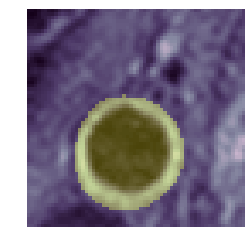

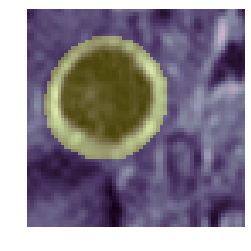

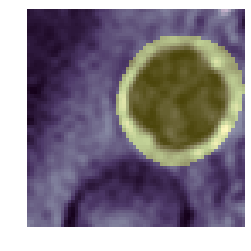

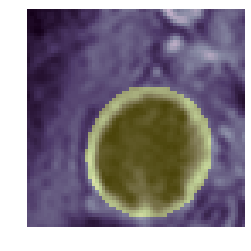

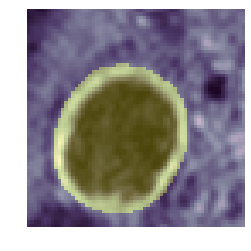

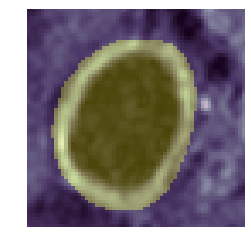

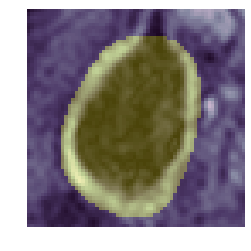

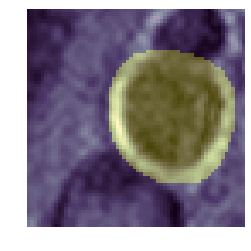

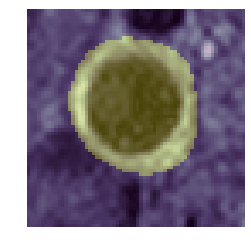

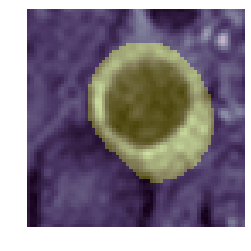

In [26]:
for i in range (0, 10):
    plt.imshow(X_train[i, ..., 0], cmap = 'bone')
    plt.imshow(y_train[i, ..., 0], alpha = 0.3)
    plt.axis('Off')
    plt.show()

In [79]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomSizedCrop(min_max_height=(48, 64), height=64, width=64, p=0.5),
    A.VerticalFlip(p=0.5),
    A.Blur(p=0.5),
    A.GaussNoise(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25, p=0.5),
    A.RandomGamma(p=0.5)
])

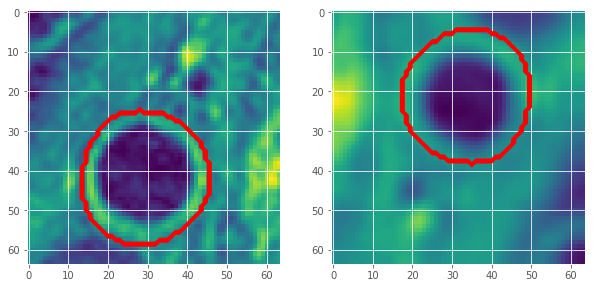

In [96]:
#random.seed(0)

transformed = transform(image=X_train[0, ..., 0], mask=y_train[0, ..., 0])
transformed_image = transformed['image']
transformed_mask = transformed['mask']

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(X_train[0, ..., 0])
plt.contour(y_train[0, ..., 0], colors='r')
plt.subplot(122)
plt.imshow(transformed_image)
plt.contour(transformed_mask, colors='r')
plt.show()

In [71]:
def augment_ds(X, y, n_augms):
    
    counter = 0
    dim = y[0, ..., 0].shape
    n_samples = y.shape[0]
    
    X_aug = np.zeros((int(n_samples*n_augms), dim[0], dim[1], 1), dtype = np.uint8)
    y_aug = np.zeros((int(n_samples*n_augms), dim[0], dim[1], 1), dtype = np.uint8)
    
    for smpl in range (0, n_samples):
        for augm in range (0, n_augms):
            
            random.seed(counter)
            augmented = transform(image=X[smpl, ..., 0], mask=y[smpl, ..., 0])
            X_aug[counter, ..., 0] = augmented['image']
            y_aug[counter, ..., 0] = augmented['mask']
            counter += 1
            
    return X_aug, y_aug    

In [97]:
X_train_aug, y_train_aug = augment_ds(X_train, y_train, 10)
X_valid_aug, y_valid_aug = augment_ds(X_train, y_train, 10)

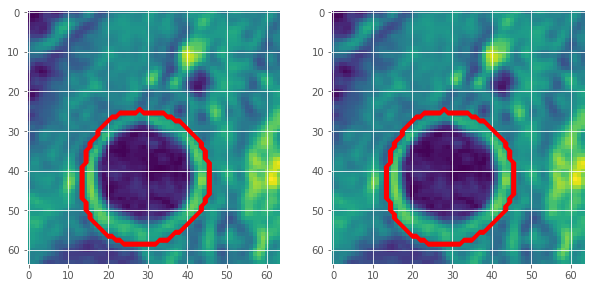

In [115]:
n_sample = 5

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(X_train[n_sample//10, ..., 0])
plt.contour(y_train[n_sample//10, ..., 0], colors='r')
plt.subplot(122)
plt.imshow(X_train_aug[n_sample, ..., 0])
plt.contour(y_train_aug[n_sample, ..., 0], colors='r')
plt.show()

In [98]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def get_unet(input_img, n_filters = 8, dropout = 0.2, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [99]:
def dice_coef(y_true, y_pred):
    from keras import backend as K
    smooth=1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [100]:
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def custom_loss(y_true, y_pred):
    from keras.losses import binary_crossentropy
    return 0.5*keras.losses.binary_crossentropy(y_true,y_pred)+0.5*dice_loss(y_true,y_pred)

In [101]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [102]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss=custom_loss, metrics=['accuracy', dice_coef])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 64, 64, 16)   160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 64, 64, 16)   64          conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 64, 64, 16)   0           batch_normalization_20[0][0]     
__________________________________________________________________________________________________
max_poolin

In [103]:
callbacks = [
    #EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model_vessel-detection.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [116]:
results = model.fit(X_train_aug, y_train_aug, 
                    batch_size=32, epochs=100, callbacks=callbacks, validation_data=(X_valid_aug, y_valid_aug))

W0407 20:01:01.069078 21616 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0407 20:01:01.520336 21616 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W0407 20:01:02.130495 21616 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:199: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.



Train on 15890 samples, validate on 15890 samples
Epoch 1/100


W0407 20:01:03.759735 21616 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



15890/15890 [==============================] - 36s 2ms/step - loss: 0.2563 - acc: 0.9088 - dice_coef: 0.7248 - val_loss: 0.2263 - val_acc: 0.9206 - val_dice_coef: 0.7780

Epoch 00001: val_loss improved from inf to 0.22625, saving model to model_vessel-detection.h5
Epoch 2/100
15890/15890 [==============================] - 26s 2ms/step - loss: 0.1640 - acc: 0.9399 - dice_coef: 0.8328 - val_loss: 0.1759 - val_acc: 0.9393 - val_dice_coef: 0.8105

Epoch 00002: val_loss improved from 0.22625 to 0.17595, saving model to model_vessel-detection.h5
Epoch 3/100
15890/15890 [==============================] - 26s 2ms/step - loss: 0.1431 - acc: 0.9474 - dice_coef: 0.8560 - val_loss: 0.1596 - val_acc: 0.9491 - val_dice_coef: 0.8233

Epoch 00003: val_loss improved from 0.17595 to 0.15962, saving model to model_vessel-detection.h5
Epoch 4/100
15890/15890 [==============================] - 26s 2ms/step - loss: 0.1312 - acc: 0.9516 - dice_coef: 0.8681 - val_loss: 0.1320 - val_acc: 0.9567 - val_dice_coef

15890/15890 [==============================] - 26s 2ms/step - loss: 0.0322 - acc: 0.9876 - dice_coef: 0.9667 - val_loss: 0.0314 - val_acc: 0.9908 - val_dice_coef: 0.9596

Epoch 00062: val_loss did not improve from 0.03037
Epoch 63/100
15890/15890 [==============================] - 26s 2ms/step - loss: 0.0321 - acc: 0.9877 - dice_coef: 0.9669 - val_loss: 0.0299 - val_acc: 0.9909 - val_dice_coef: 0.9622

Epoch 00063: val_loss improved from 0.03037 to 0.02995, saving model to model_vessel-detection.h5
Epoch 64/100
15890/15890 [==============================] - 26s 2ms/step - loss: 0.0320 - acc: 0.9877 - dice_coef: 0.9670 - val_loss: 0.0299 - val_acc: 0.9910 - val_dice_coef: 0.9620

Epoch 00064: val_loss improved from 0.02995 to 0.02995, saving model to model_vessel-detection.h5
Epoch 65/100
15890/15890 [==============================] - 26s 2ms/step - loss: 0.0317 - acc: 0.9878 - dice_coef: 0.9673 - val_loss: 0.0304 - val_acc: 0.9909 - val_dice_coef: 0.9614

Epoch 00065: val_loss did not 

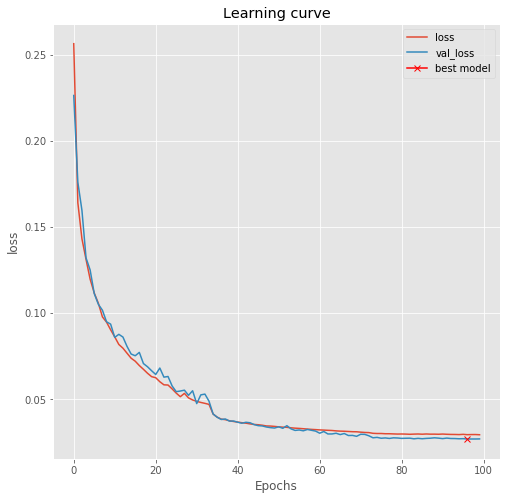

In [117]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend();

In [118]:
model.load_weights('model_vessel-detection.h5')

In [119]:
model.evaluate(X_valid, y_valid, verbose=1)

345/345 [==============================] - 1s 2ms/step


[0.21603050089400747, 0.9478374085564544, 0.8720289667447408]

In [120]:
model.evaluate(X_test, y_test, verbose=1)

360/360 [==============================] - 1s 2ms/step


[0.19009632964928944, 0.9543714735243055, 0.8795947564972771]

In [34]:
# Predict on val and test
#preds_test = model.predict(X_test, verbose=1)
#preds_valid = model.predict(X_valid, verbose=1)

# Threshold predictions
#preds_test_t = (preds_test > 0.5).astype(np.uint8)
#preds_valid_t = (preds_valid > 0.5).astype(np.uint8)

In [35]:
#ix = 90

#fig, ax = plt.subplots(1, 3, figsize=(20, 10))
#ax[0].imshow(X_valid[ix, ..., 0], cmap='viridis')
#ax[0].contour(y_valid[ix].squeeze(), colors='r', levels=[0.5], linewidths=5)
#ax[0].set_title('True')
#ax[0].grid(False)

#ax[1].imshow(X_valid[ix, ..., 0], cmap='viridis')
#ax[1].contour(preds_valid[ix].squeeze(), colors='r', levels=[0.5], linewidths=5)
#ax[1].set_title('Predicted')
#ax[1].grid(False)

#ax[2].imshow(y_valid[ix].squeeze(), vmin=0, vmax=2)
#ax[2].contour(preds_valid[ix].squeeze(), colors='r', levels=[0.5], linewidths=5)
#ax[2].set_title('Predicted segmentation')
#ax[2].grid(False)

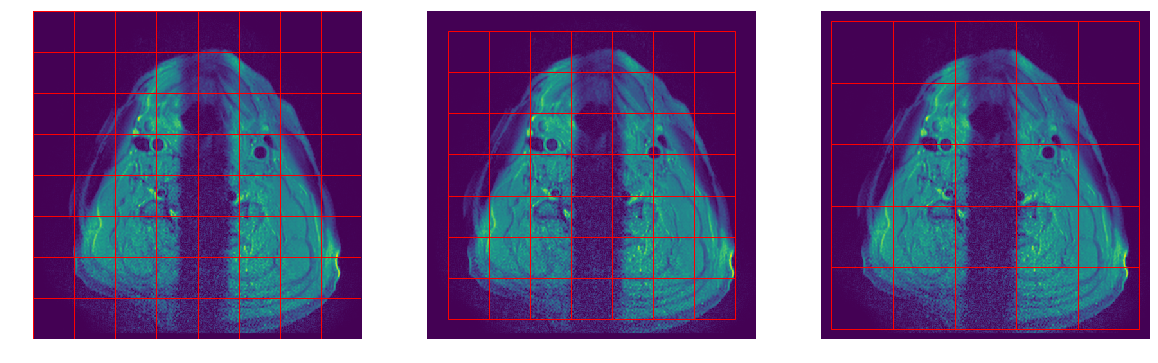

In [121]:
img_dcm = pydicom.read_file(img_names_test[0], force = True)
img_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
img = img_dcm.pixel_array
#img_min = np.min(img)
#img_max = np.max(img)
#img_norm = np.copy((img - img_min)/(img_max - img_min)*255).astype(np.uint8)

#img_test = img_norm[8:-8,8:-8]
img_test = img[8:-8,8:-8]

plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(img_test)
for i in range (0, 8):
    for j in range (0, 8):
        plt.gca().add_patch(patches.Rectangle((64*i, 64*j), 64, 64, linewidth=1, edgecolor='r', facecolor='none'))
plt.axis('Off')


plt.subplot(1, 3, 2)
plt.imshow(img_test)
for i in range (0, 7):
    for j in range (0, 7):
        plt.gca().add_patch(patches.Rectangle((32+64*i, 32+64*j), 64, 64, linewidth=1, edgecolor='r', facecolor='none'))
plt.axis('Off')


plt.subplot(1, 3, 3)
plt.imshow(img_test)
for i in range (0, 5):
    for j in range (0, 5):
        plt.gca().add_patch(patches.Rectangle((16+96*i, 16+96*j), 96, 96, linewidth=1, edgecolor='r', facecolor='none'))
plt.axis('Off')
plt.show()

In [127]:
con_name = glob.glob(os.path.join(os.path.split(img_names_test[0])[0],
                                  'MASSExport')+os.sep+'*'+ img_names_test[0].split(os.sep)[2][-10:-4]+'*.dcm')[0]
con_test = path2array(con_name)[8:-8,8:-8]>0

In [ ]:
#def detect4patches(img):
    
#    M_0 = np.zeros((512, 512), dtype = np.float)
#    M_1 = np.zeros((512, 512), dtype = np.float)
#    M_2 = np.zeros((512, 512), dtype = np.float)

#    for i in range (0, 8):
#        for j in range (0, 8):
#            img_patch = np.zeros((1, 64, 64, 1))
#            img_patch[0, ..., 0] = img[64*i:64*i+64, 64*j:64*j+64].copy()
#            img_patch_pred = model.predict(img_patch, verbose=1)
#            M_0[64*i:64*i+64, 64*j:64*j+64] = img_patch_pred[0, ..., 0]

#    for i in range (0, 7):
#        for j in range (0, 7):
#            img_patch = np.zeros((1, 64, 64, 1))
#            img_patch[0, ..., 0] = img[32+64*i:32+64*i+64, 32+64*j:32+64*j+64].copy()
#            img_patch_pred = model.predict(img_patch, verbose=1)
#            M_1[32+64*i:32+64*i+64, 32+64*j:32+64*j+64] = img_patch_pred[0, ..., 0]

#    for i in range (0, 5):
#        for j in range (0, 5):
#            img_patch = np.zeros((1, 64, 64, 1))
#            img_patch[0, ..., 0] = res = cv2.resize(img[16+96*i:16+96*i+96, 16+96*j:16+96*j+96].copy(),
                                                    dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
#            mask_pred = model.predict(img_patch, verbose=1)
#            img_patch_pred = cv2.resize(mask_pred[0, ..., 0],
                                        dsize=(96, 96), interpolation=cv2.INTER_CUBIC)
#            M_2[16+96*i:16+96*i+96, 16+96*j:16+96*j+96] = img_patch_pred
            
#    M_fuzed = (M_0+M_1+M_2)/3
    
#    return M_fuzed

In [ ]:
#vessels_pred_simple = detect4patches(img_test)

In [ ]:
#plt.figure(figsize=(10, 10))

#plt.imshow(img_test)
#plt.contour(vessels_pred_simple, colors = 'r')

#plt.show()

In [ ]:
#vessels_pred_simple_th = vessels_pred_simple > 0.5
#vessels_pred_simple_th_morph = morphology.remove_small_objects(vessels_pred_simple_th, 100, connectivity=3)

#global_thresh = threshold_otsu(vessels_pred_simple)
#vessels_pred_simple_otsu = (vessels_pred_simple>global_thresh)
#vessels_pred_simple_otsu_morph = morphology.remove_small_objects(vessels_pred_simple_otsu, 100, connectivity=3)

In [122]:
def detect4multipatches(img):
    
    img_min = np.min(img)
    img_max = np.max(img)
    
    img_norm = ((img-img_min)/(img_max-img_min)*255).astype(np.uint8)
    
    steps = int((img.shape[0]-64)/4)+1
    
    M = np.empty((512, 512, steps*steps))
    M[:] = np.NaN
    img_patch = np.zeros((steps*steps, 64, 64, 1))
    c = 0

    for i in range (0, steps):
        for j in range (0, steps):
            
            img_norm_crop = img_norm[4*i:4*i+64, 4*j:4*j+64]
            img_patch[c, ..., 0] = img_norm_crop.copy()
            c += 1
            
    img_patch_pred = model.predict(img_patch, verbose=1)
    
    c = 0
    for i in range (0, steps):
        for j in range (0, steps):
            M[4*i:4*i+64, 4*j:4*j+64, c] = img_patch_pred[c, ..., 0]
            c += 1
            
    M_concord = np.nanmean(M, axis = 2)
    
    del M
            
    return M_concord

In [123]:
#vessels_pred_multi, M = detect4multipatches(img_test)
vessels_pred_multi = detect4multipatches(img_test)

12769/12769 [==============================] - 6s 464us/step


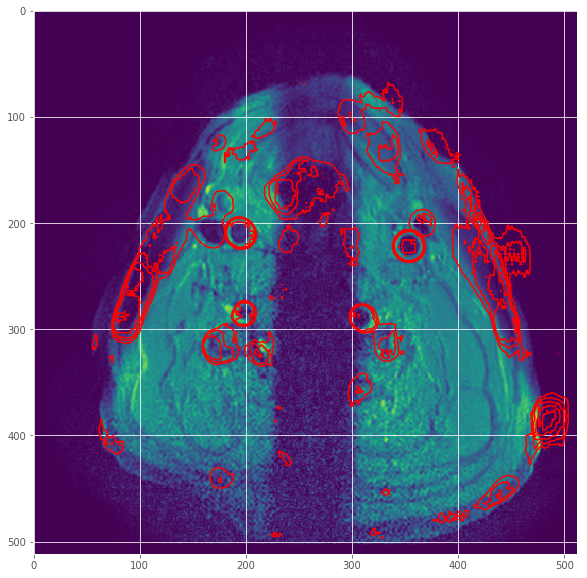

In [124]:
plt.figure(figsize=(10, 10))

plt.imshow(img_test)
plt.contour(vessels_pred_multi, colors = 'r')

plt.show()

In [ ]:
#plt.figure(figsize=(20, 20))

#plt.subplot(1, 4, 1)
#plt.imshow(img_test)
#for i in range (0, 1):
#    for j in range (0, 1):
#        plt.gca().add_patch(patches.Rectangle((64*i, 64*j), 64, 64, linewidth=1, edgecolor='r', facecolor='none'))

#plt.subplot(1, 4, 2)
#plt.imshow(M[..., 5000], vmin = 0, vmax = 1)

#plt.subplot(1, 4, 3)
#plt.imshow(M[..., 7500], vmin = 0, vmax = 1)

#plt.subplot(1, 4, 4)
#plt.imshow(vessels_pred_multi)
        
#plt.show()

In [131]:
vessels_pred_multi_th = vessels_pred_multi > 0.7
vessels_pred_multi_th_morph = morphology.remove_small_objects(vessels_pred_multi_th, 100, connectivity=3)

global_thresh = threshold_otsu(vessels_pred_multi)
vessels_pred_multi_otsu = (vessels_pred_multi>global_thresh)
vessels_pred_multi_otsu_morph = morphology.remove_small_objects(vessels_pred_multi_otsu, 100, connectivity=3)

In [ ]:
#plt.figure(figsize=(20, 10))

#plt.subplot(2, 4, 1)
#plt.imshow(img_test)
#plt.contour(vessels_pred_simple_th, colors = 'r')

#plt.subplot(2, 4, 2)
#plt.imshow(img_test)
#plt.contour(vessels_pred_simple_th_morph, colors = 'r')

#plt.subplot(2, 4, 3)
#plt.imshow(img_test)
#plt.contour(vessels_pred_simple_otsu, colors = 'r')

#plt.subplot(2, 4, 4)
#plt.imshow(img_test)
#plt.contour(vessels_pred_simple_otsu_morph, colors = 'r')

#plt.subplot(2, 4, 5)
#plt.imshow(img_test)
#plt.contour(vessels_pred_multi_th, colors = 'r')

#plt.subplot(2, 4, 6)
#plt.imshow(img_test)
#plt.contour(vessels_pred_multi_th_morph, colors = 'r')

#plt.subplot(2, 4, 7)
#plt.imshow(img_test)
#plt.contour(vessels_pred_multi_otsu, colors = 'r')

#plt.subplot(2, 4, 8)
#plt.imshow(img_test)
#plt.contour(vessels_pred_multi_otsu_morph, colors = 'r')

#plt.show()

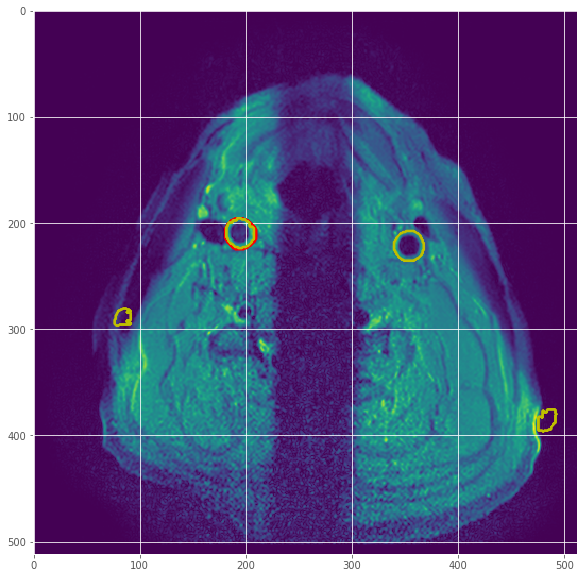

In [132]:
plt.figure(figsize=(10, 10))

plt.imshow(img_test)
plt.contour(con_test, colors = 'r')
plt.contour(vessels_pred_multi_th_morph, colors = 'y')

plt.show()

In [133]:
def calculate_dice(mask_1, mask_2):
    intersection = np.sum(mask_1*mask_2)
    sum_area = np.sum(mask_1) + np.sum(mask_2)
    return 2*intersection/sum_area

def calculate_overlap(mask_1, mask_2):
    intersection = np.sum(mask_1*mask_2)
    min_area = min(np.sum(mask_1), np.sum(mask_2))
    return intersection/min_area

In [134]:
max_overlap = 0
component_label = 0
component_dice = 0

vessels_pred_multi_th_morph_labeled = label(vessels_pred_multi_th_morph)

for l in range(1, np.max(vessels_pred_multi_th_morph_labeled)+1):
    l_mask = vessels_pred_multi_th_morph_labeled==l
    d = calculate_dice(l_mask, con_test)
    o = calculate_overlap(l_mask, con_test)
    if o>max_overlap:
        max_overlap = o
        component_label = l
        component_dice = d
        
if max_overlap > 0.5:
    
    vessel_mask = vessels_pred_multi_th_morph_labeled==component_label
    
    if np.sum(con_test)>0:
        detected = 1
        
    print (max_overlap, component_dice, detected)

1.0 0.9077669902912622 1
